In [2]:
import pandas as pd
import numpy as np
from common import collect_results, normalize_region_name
from pathlib import Path
from matplotlib import pyplot as plt

In [3]:
ROOT = Path("ycsb")

def get_matcher(prefix):
    def matcher(p: Path):   
        import re
        pattern = re.compile(prefix + r"-hot(\d+)-(\w)-mr(\d+)-([\d-]+)")
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        hot = int(match.group(1))
        return {
            "hot": 1000000 if hot == 0 else hot,
            "workload": str(match.group(2)),
            "mr": int(match.group(3)),
            "suffix": str(match.group(4)),
        }
    
    return matcher

# Throughput


In [4]:
SYSTEMS = ["sunstorm", "aurora", "yugabyte"]
HOTS = [100000, 10000, 1000]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("ycsb-throughput-sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "throughput-sunstorm",
    sunstorm_matcher,
    RENEW_CACHE,
)
sunstorm_throughput_df["system"] = "sunstorm"

aurora_matcher = get_matcher("ycsb-throughput-aurora")
aurora_throughput_df = collect_results(
    ROOT / "throughput-aurora",
    aurora_matcher,
    RENEW_CACHE,
)
aurora_throughput_df["system"] = "aurora"

yugabyte_matcher = get_matcher("ycsb-throughput-yugabyte")
yugabyte_throughput_df = collect_results(
    ROOT / "throughput-yugabyte",
    yugabyte_matcher,
    RENEW_CACHE,
)
yugabyte_throughput_df["system"] = "yugabyte"

In [5]:
throughput_df = pd.concat([
    sunstorm_throughput_df,
    aurora_throughput_df,
    yugabyte_throughput_df,
])
throughput_df["HOT"] = 1 / throughput_df["hot"]
normalize_region_name(throughput_df)
throughput_df

,path,region,hot,workload,mr,suffix,rejected,rejected.WorkloadF1,aborted,unexpected,...,p50.WorkloadF3,p75.WorkloadF3,p90.WorkloadF3,p95.WorkloadF3,p99.WorkloadF3,p100.WorkloadF3,unexpected.WorkloadF2,unexpected.WorkloadF3,system,HOT
0,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,2-us-east-2-0,1000000,F,0,20240216-134548,1225,1225,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,0.000001
1,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,1-us-east-1-0,1000000,F,0,20240216-134548,1244,1244,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,0.000001
2,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,3-us-west-1-0,1000000,F,0,20240216-134548,1439,1439,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,0.000001
3,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,2-us-east-2-0,10000,F,15,20240216-144516,7567,3315,0,0,...,69.4435,73.0400,111.0110,136.34850,156.53250,221.9810,NaN,NaN,sunstorm,0.000100
4,ycsb/throughput-sunstorm/ycsb-throughput-sunst...,1-us-east-1-0,10000,F,15,20240216-144516,7541,3206,0,0,...,77.5030,80.3150,117.0125,151.87350,171.60750,241.6795,NaN,NaN,sunstorm,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,1-us-east-1-0,10000,F,50,20240213-172604,5817,1281,0,0,...,325.8080,377.3590,420.3288,451.20700,494.95956,600.1920,NaN,NaN,yugabyte,0.000100
56,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,3-us-west-1-0,10000,F,50,20240213-172604,5254,1111,0,0,...,477.5940,506.9630,559.5650,571.14060,625.75146,749.2180,NaN,NaN,yugabyte,0.000100
57,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,2-us-east-2-0,10000,F,5,20240213-172604,4270,3654,0,0,...,352.0810,395.0040,435.1308,461.26140,503.64828,595.3530,NaN,NaN,yugabyte,0.000100
58,ycsb/throughput-yugabyte/ycsb-throughput-yugab...,1-us-east-1-0,10000,F,5,20240213-172604,4187,3574,0,0,...,380.1825,431.3705,475.3660,509.11900,556.61240,627.4060,NaN,NaN,yugabyte,0.000100


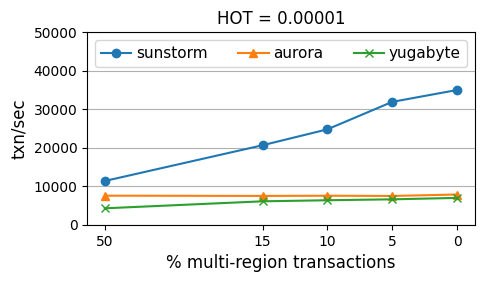

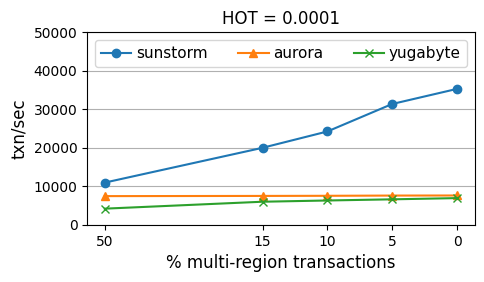

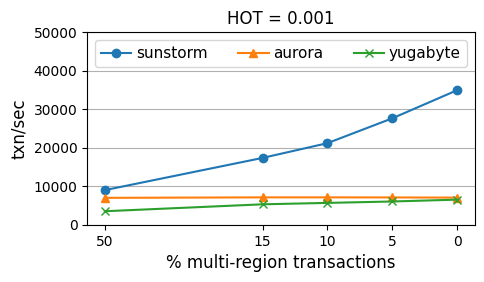

In [10]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for hot in HOTS:
    hot_df = throughput_df[throughput_df.hot == hot]
    hot_label = f"{1/hot:.5f}".rstrip("0")
    ax = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="throughput", aggfunc="sum"
    )[SYSTEMS].plot(
        title=f"HOT = {hot_label}",
        xlabel="% multi-region transactions",
        ylabel="txn/sec",
        figsize=(5, 2.5),
        style=["o-", "^-", "x-"],
        ylim=(0, 50000),
        rot=0,
    )
    ax.set_xscale("symlog", linthresh=20)
    ax.set_xticks([0, 5, 10, 15, 50])
    ax.set_xticklabels([0, 5, 10, 15, 50])
    ax.margins(x=0.05)
    ax.grid(axis="y")
    ax.legend(title="", ncol=3, handletextpad=0.3)
    ax.invert_xaxis()
    plt.savefig(f"output/micro-throughput-hot{hot}.pdf", bbox_inches="tight")


# Errors


## Single-home

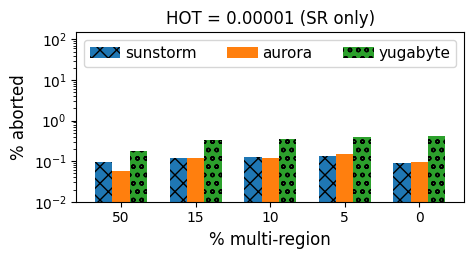

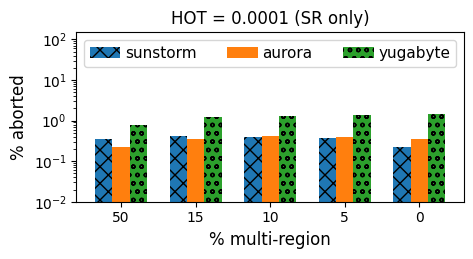

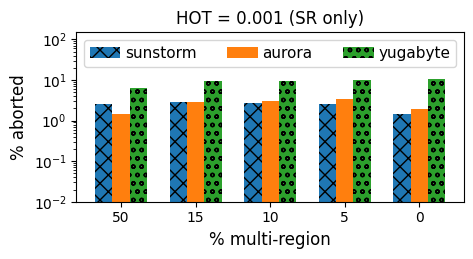

In [18]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for hot in HOTS:
    hot_df = throughput_df[throughput_df.hot == hot]
    aborted_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="rejected.WorkloadF1", aggfunc="sum"
    )
    completed_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="completed", aggfunc="sum"
    )
    ratio_df = aborted_df / (aborted_df + completed_df) * 100

    hot_label = f"{1/hot:.5f}".rstrip("0")
    ax = ratio_df[reversed(SYSTEMS)].plot.bar(
        title=f"HOT = {hot_label} (SR only)",
        xlabel="% multi-region",
        ylabel="% aborted",
        figsize=(5, 2.2),
        rot=0,
        width=0.7,
        color=["C2", "C1", "C0"],
    )
    bars = ax.patches
    patterns = ["oo", "", "xx"]
    hatches = [p for p in patterns for _ in range(len(bars) // len(patterns))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.legend(reversed(legend_handles), reversed(legend_labels), title="", ncol=3, handletextpad=0.3)
    ax.invert_xaxis()
    
    ax.margins(y=0.4)
    plt.savefig(f"output/micro-abort-sr-hot{hot}.pdf", bbox_inches="tight")

    ax.set_yscale("log")
    ax.set_ylim(0.01, 150)
    plt.savefig(f"output/micro-abort-sr-hot{hot}-logy.pdf", bbox_inches="tight")

## Multi-home

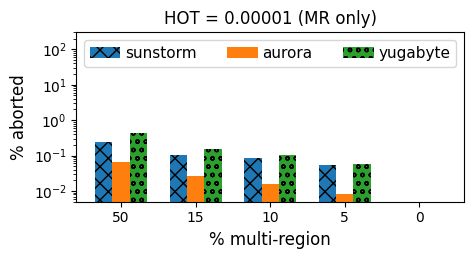

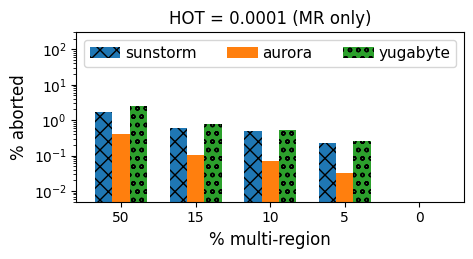

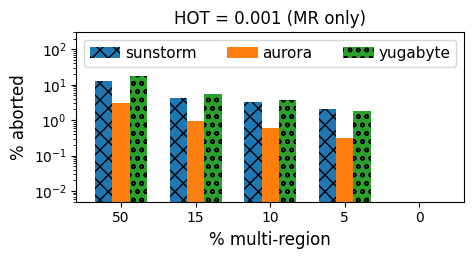

In [19]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for hot in HOTS:
    hot_df = throughput_df[throughput_df.hot == hot]
    rejected_2_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="rejected.WorkloadF2", aggfunc="sum"
    )
    rejected_3_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="rejected.WorkloadF3", aggfunc="sum"
    )
    completed_df = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="completed", aggfunc="sum"
    )
    aborted_df = rejected_2_df + rejected_3_df
    ratio_df = aborted_df / (aborted_df + completed_df) * 100

    hot_label = f"{1/hot:.5f}".rstrip("0")
    ax = ratio_df[reversed(SYSTEMS)].plot.bar(
        title=f"HOT = {hot_label} (MR only)",
        xlabel="% multi-region",
        ylabel="% aborted",
        figsize=(5, 2.2),
        rot=0,
        width=0.7,
        color=["C2", "C1", "C0"],
    )
    bars = ax.patches
    patterns = ["oo", "", "xx"]
    hatches = [p for p in patterns for _ in range(len(bars) // len(patterns))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch, )

    legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.legend(reversed(legend_handles), reversed(legend_labels), title="", ncol=3, handletextpad=0.3)
    ax.invert_xaxis()

    ax.margins(y=0.3)
    plt.savefig(f"output/micro-abort-mr-hot{hot}.pdf", bbox_inches="tight")

    ax.set_yscale("log")
    ax.set_ylim(0.005, 300)
    plt.savefig(f"output/micro-abort-mr-hot{hot}-logy.pdf", bbox_inches="tight")


## SunStorm error types

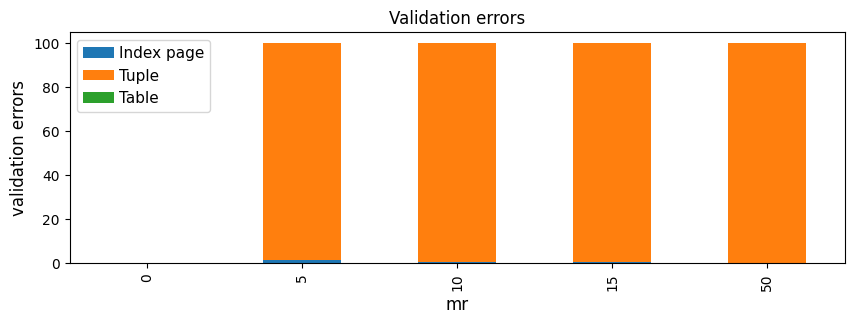

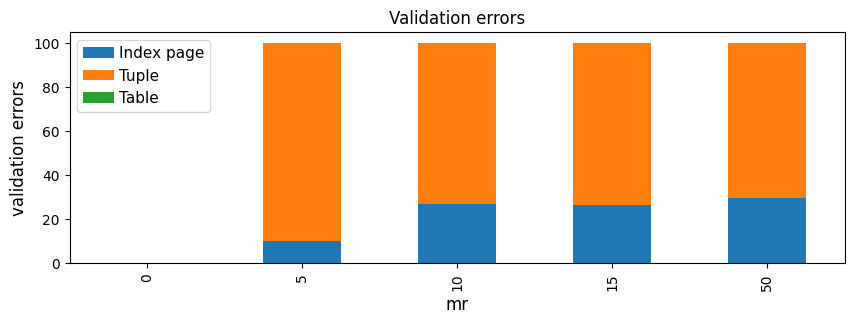

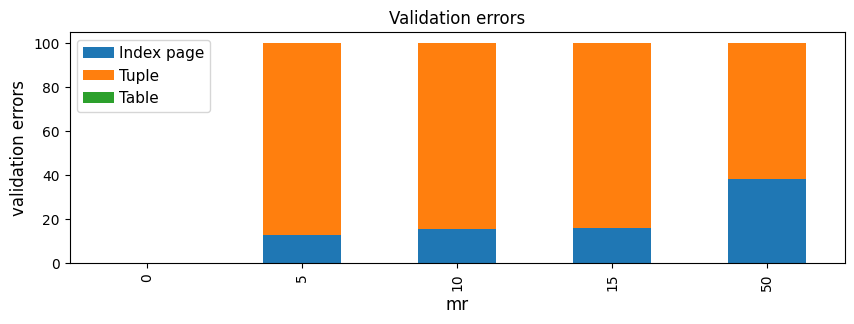

In [22]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

sunstorm_df = throughput_df[throughput_df.system == "sunstorm"]
for hot in HOTS:
    hot_df = sunstorm_df[sunstorm_df.hot == hot]\
        .groupby(["mr"])\
        .sum()
    mh_aborts = hot_df["ood_tuple"] + hot_df["ood_index_page"]  + hot_df["ood_table"]
    hot_df["ood_index_page_pct"] = hot_df["ood_index_page"] / mh_aborts * 100
    hot_df["ood_tuple_pct"] = hot_df["ood_tuple"] / mh_aborts * 100
    hot_df["ood_table_pct"] = hot_df["ood_table"] / mh_aborts * 100
    ax = hot_df[["ood_index_page_pct", "ood_tuple_pct", "ood_table_pct"]].plot.bar( 
        title="Validation errors",
        ylabel="validation errors",
        figsize=(10, 3),
        stacked=True,
    )
    ax.legend(["Index page", "Tuple", "Table"], title="", ncol=1, handletextpad=0.3)
    


# Latency


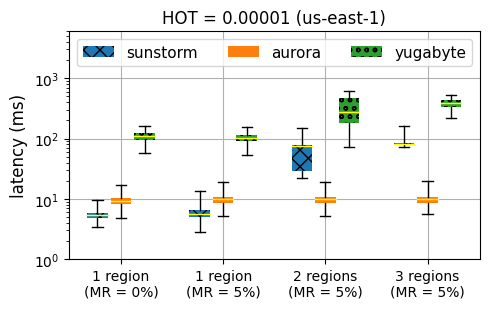

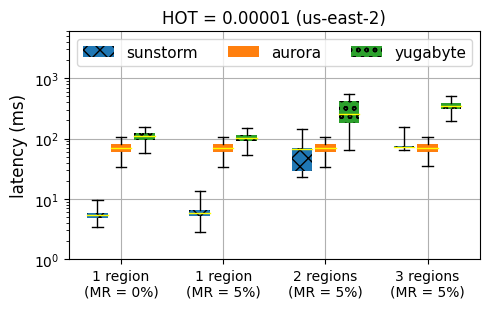

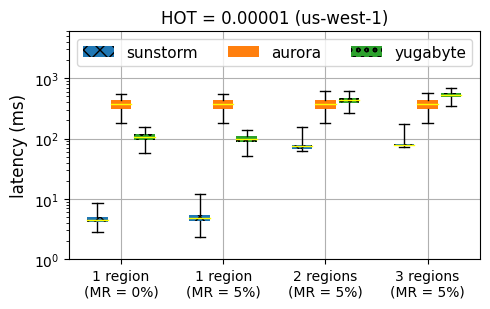

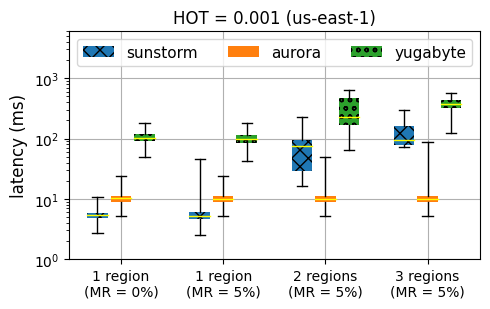

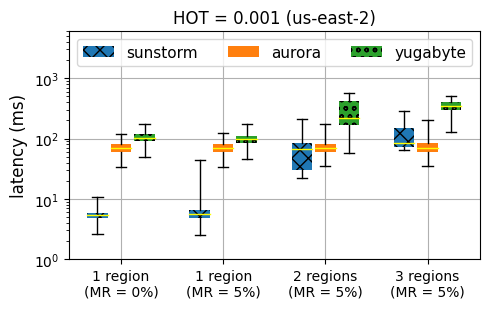

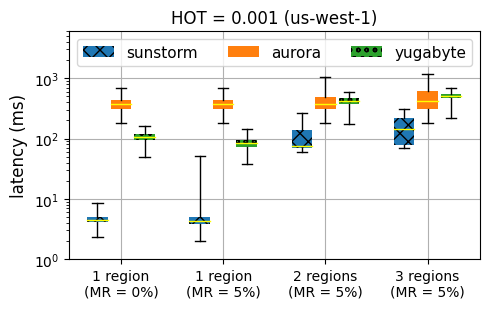

In [23]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

labels = [
    "1 region\n(MR = 0%)",
    "1 region\n(MR = 5%)",
    "2 regions\n(MR = 5%)",
    "3 regions\n(MR = 5%)",
]
ticks = np.arange(len(labels))

width = 0.46

def to_box(df, n):
    return {
        'whislo': df[f"p0.WorkloadF{n}"].iloc[0],
        'q1': df[f"p25.WorkloadF{n}"].iloc[0],
        'med': df[f"p50.WorkloadF{n}"].iloc[0],
        'q3': df[f"p75.WorkloadF{n}"].iloc[0],
        'whishi': df[f"p99.WorkloadF{n}"].iloc[0],
        'fliers': []
    }

legends = []
patterns = ["xx", "", "oo"]

for hot in [100000, 1000]:
    hot_df = throughput_df[throughput_df.hot == hot]
    hot_label = f"{1/hot:.5f}".rstrip("0")
    for region in ["1-us-east-1", "2-us-east-2", "3-us-west-1"]:
        region_df = hot_df[hot_df.region.str.startswith(region)]

        fig, ax = plt.subplots(figsize=(5, 3.2))
        for i, system in enumerate(SYSTEMS):
            system_df = region_df[region_df.system == system]
            boxes = [
                to_box(system_df[system_df.mr == 0], 1),
                to_box(system_df[system_df.mr == 5], 1),
                to_box(system_df[system_df.mr == 5], 2),
                to_box(system_df[system_df.mr == 5], 3),
            ]
            comps = ax.bxp(
                boxes,
                positions=ticks - width / 2 + i * width / (len(SYSTEMS) - 1),
                showfliers=False,
                manage_ticks=False,
                patch_artist=True,
                widths=0.2,
                boxprops={
                    "facecolor": f"C{i}",
                    "linewidth": 0,
                    "hatch": patterns[i],
                },
                medianprops={
                    "color": "yellow",
                    "linewidth": 1,
                },
            )
            legends.append(comps["boxes"][0])

        ax.legend(legends, SYSTEMS, ncol=3)

        ax.set_xticks(labels=labels, ticks=ticks)
        ax.set_yscale("log")
        ax.set_ylim(1, 6000)
        ax.set_ylabel("latency (ms)")
        ax.grid()

        ax.set_title(f"HOT = {hot_label} ({region[2:]})")
        fig.tight_layout()
        fig.savefig(f"output/micro-latency-{region[2:]}-hot{hot}.pdf", bbox_inches="tight")


In [114]:
def plot_latency(mr, hot):
    # Remove the "-0" suffix in region name
    regions = sorted([r for r in set(throughput_df.region.unique()) if not r.endswith("-0")])
    for system in throughput_df.system.unique():
        fig, axes = plt.subplots(1, len(regions), figsize=(20, 4), sharey=True)
        fig.suptitle(f"{system}, hot = {hot}, mr = {mr}%")
        workload_df = throughput_df[
            (throughput_df.system == system)
            & (throughput_df.mr == mr)
            & (throughput_df.hot == hot)
        ]
        # Plot for each region
        for i, region in enumerate(regions):
            region_df = workload_df[workload_df.region.str.startswith(region)]
            if region_df.empty:
                continue
            # Seperate the tran sactions by the number of regions they access
            max_nregion = 3
            index = range(1, max_nregion + 1)
            nregion_latency_df = {
                "p0": [region_df[f"p0.WorkloadF{n}"].iloc[0] for n in index],
                "p25": [region_df[f"p25.WorkloadF{n}"].iloc[0] for n in index],
                "p50": [region_df[f"p50.WorkloadF{n}"].iloc[0] for n in index],
                "p75": [region_df[f"p75.WorkloadF{n}"].iloc[0] for n in index],
                "p95": [region_df[f"p95.WorkloadF{n}"].iloc[0] for n in index],
                "p99": [region_df[f"p99.WorkloadF{n}"].iloc[0] for n in index],
            }
            pd.DataFrame(nregion_latency_df, index=index).plot.bar(
                title=region,
                ylabel="latency (ms)",
                ax=axes[i],
                rot=0,
                ylim=(1, 1200),
                logy=True,
            )
            axes[i].set_xlabel("number of regions")
            axes[i].grid(axis="y")
        plt.tight_layout()

In [ ]:
plot_latency(0, 1000000)

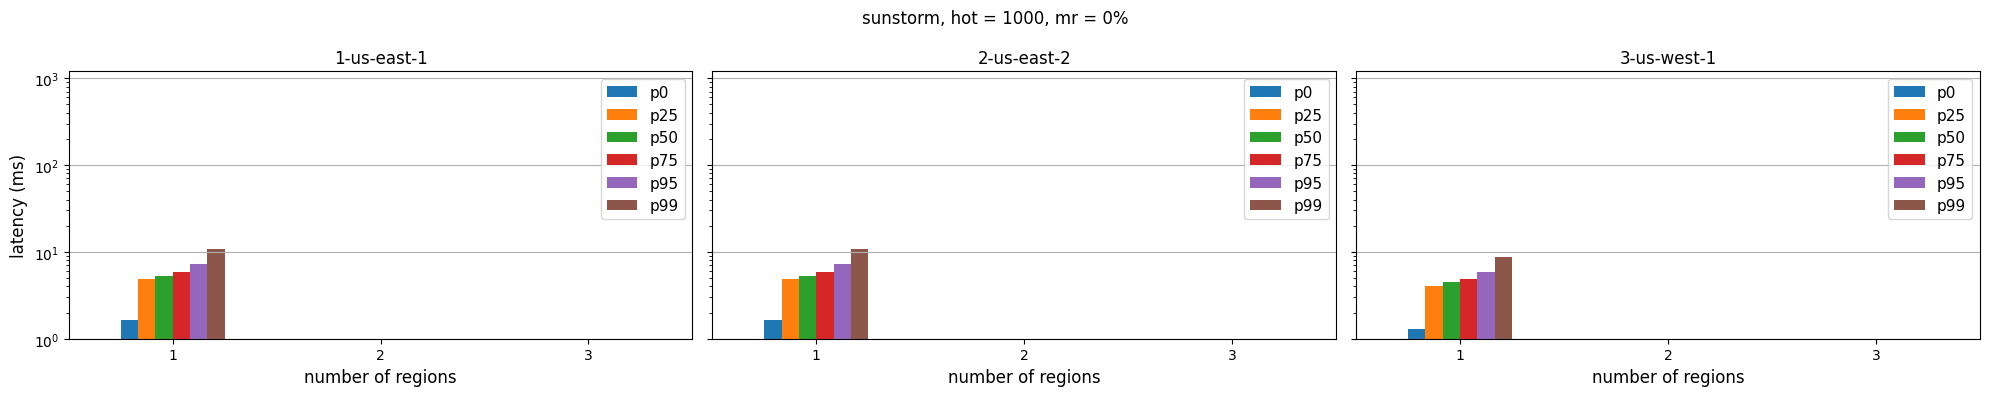

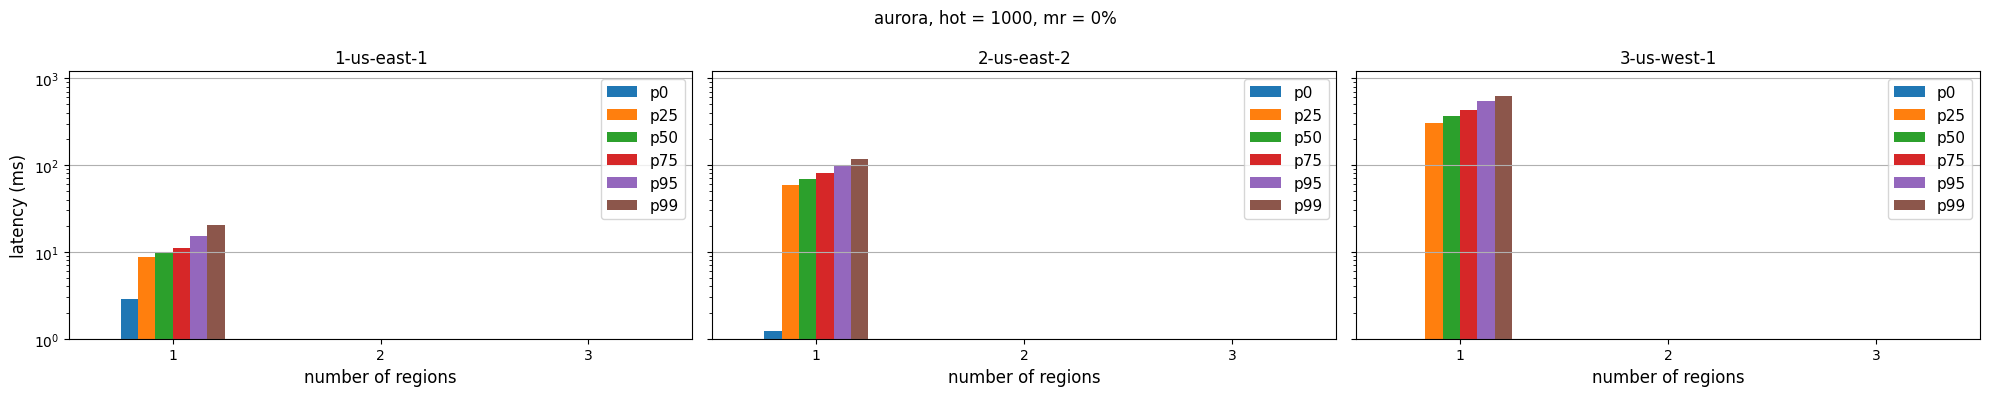

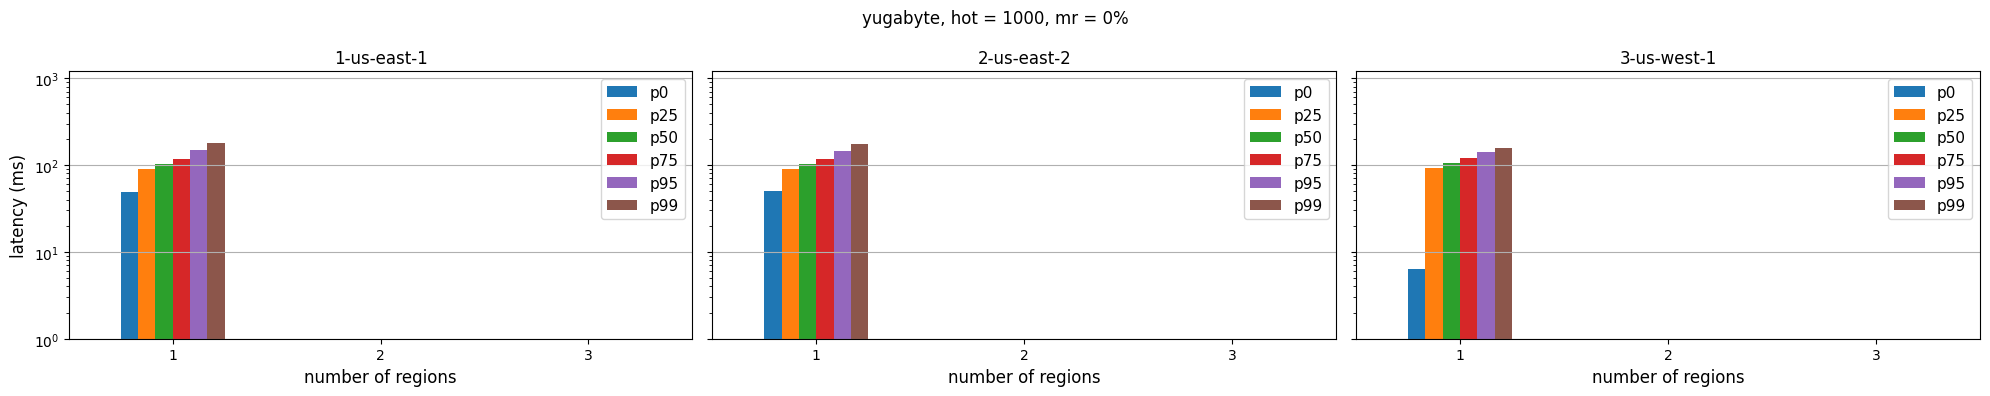

In [115]:
plot_latency(0, 1000)

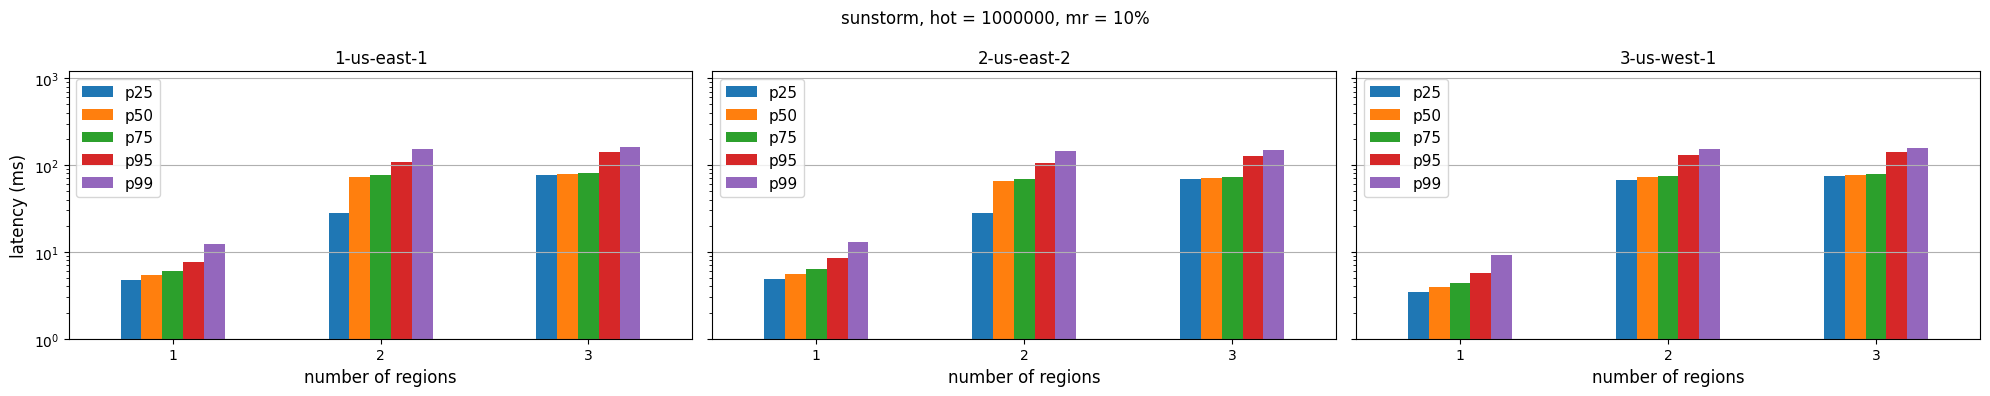

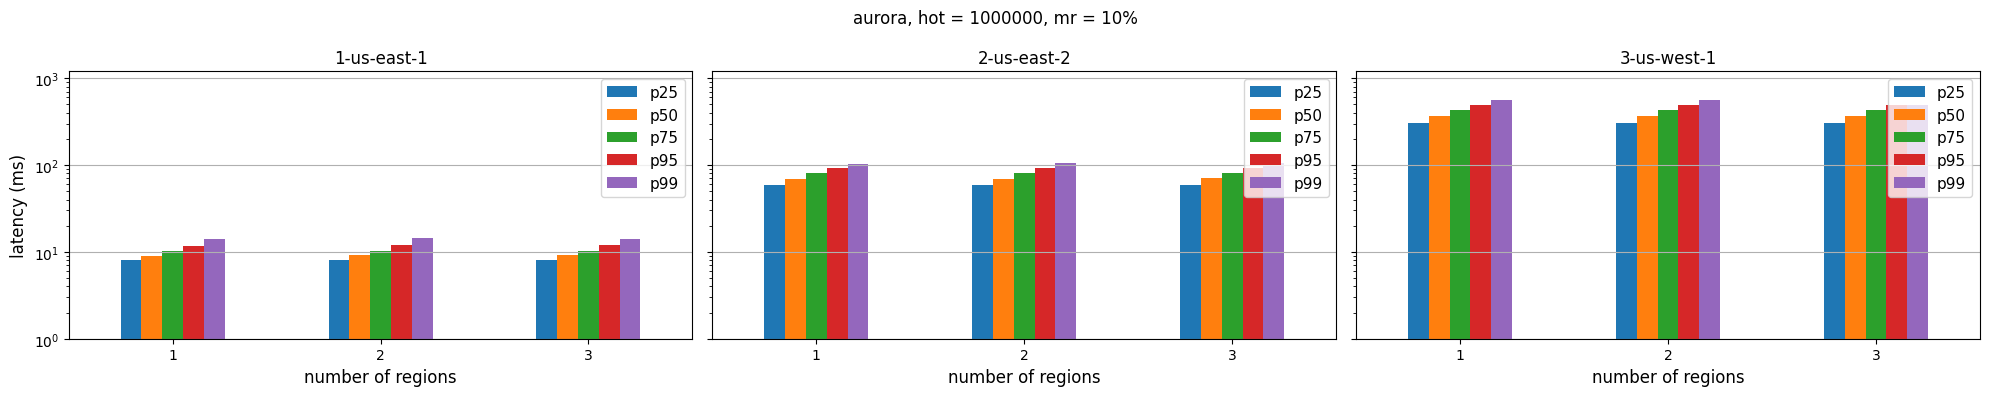

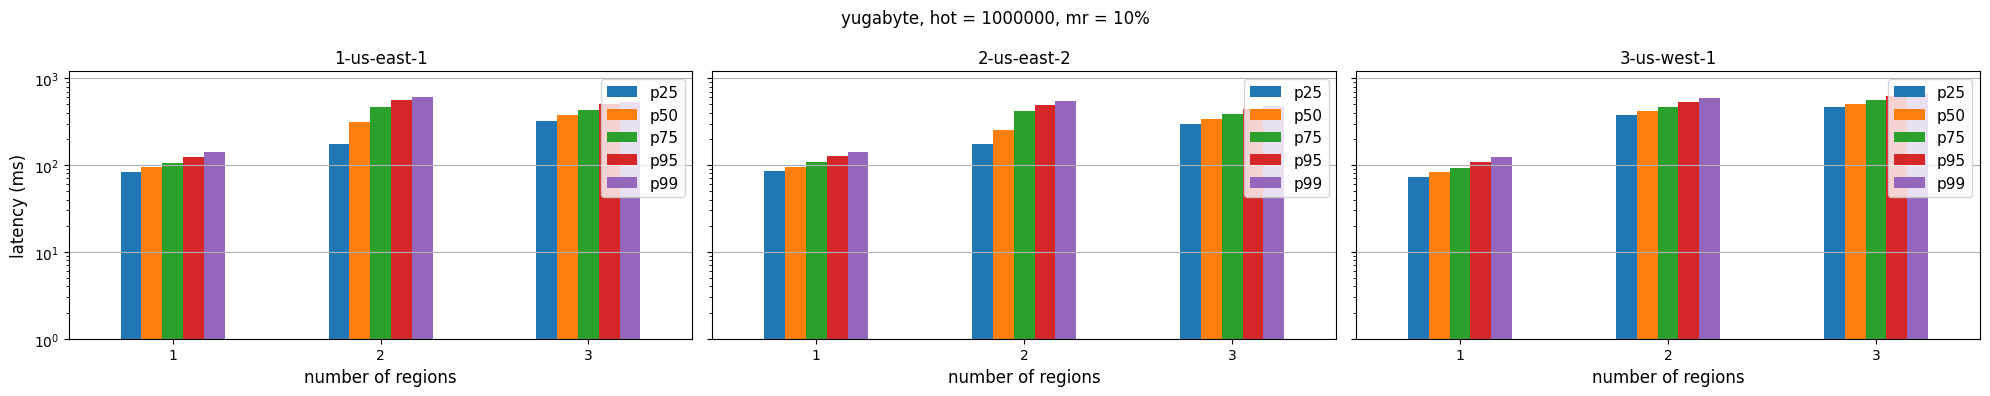

In [112]:
plot_latency(10, 1000000)

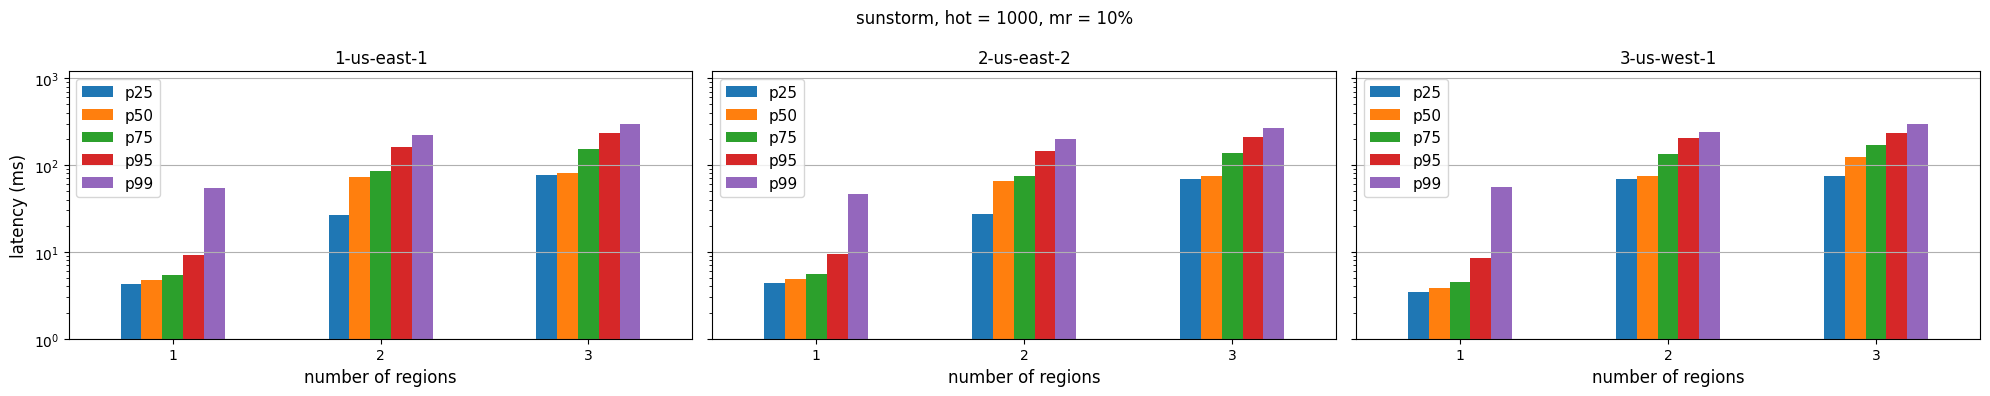

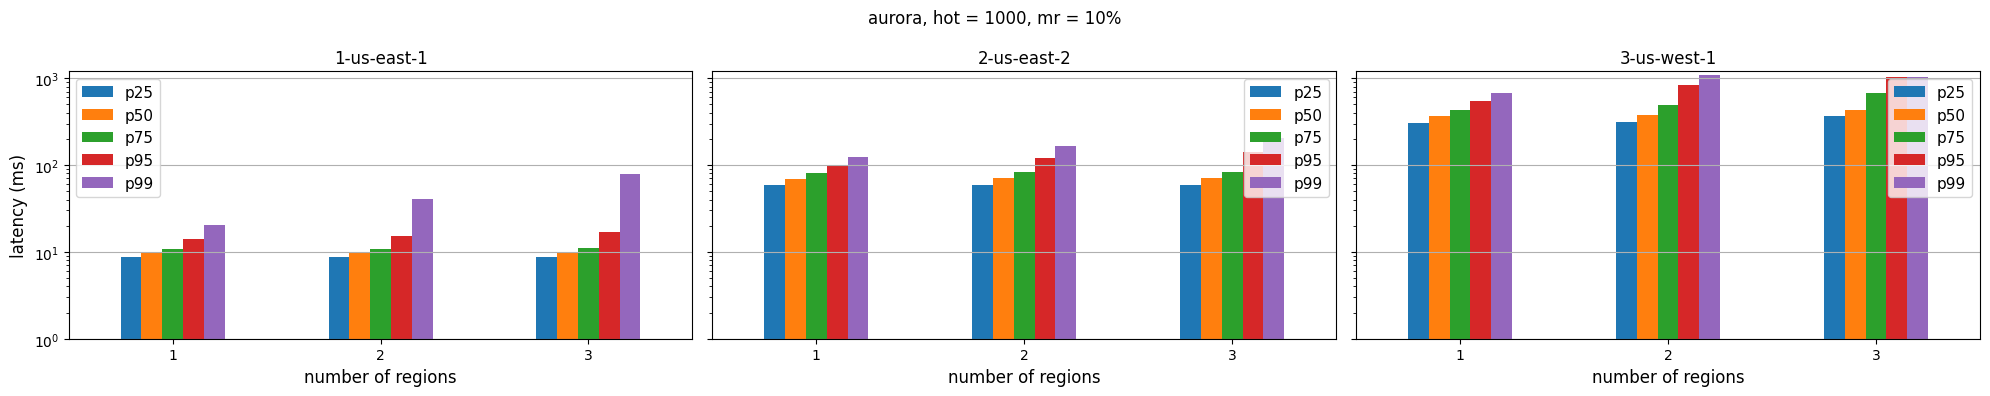

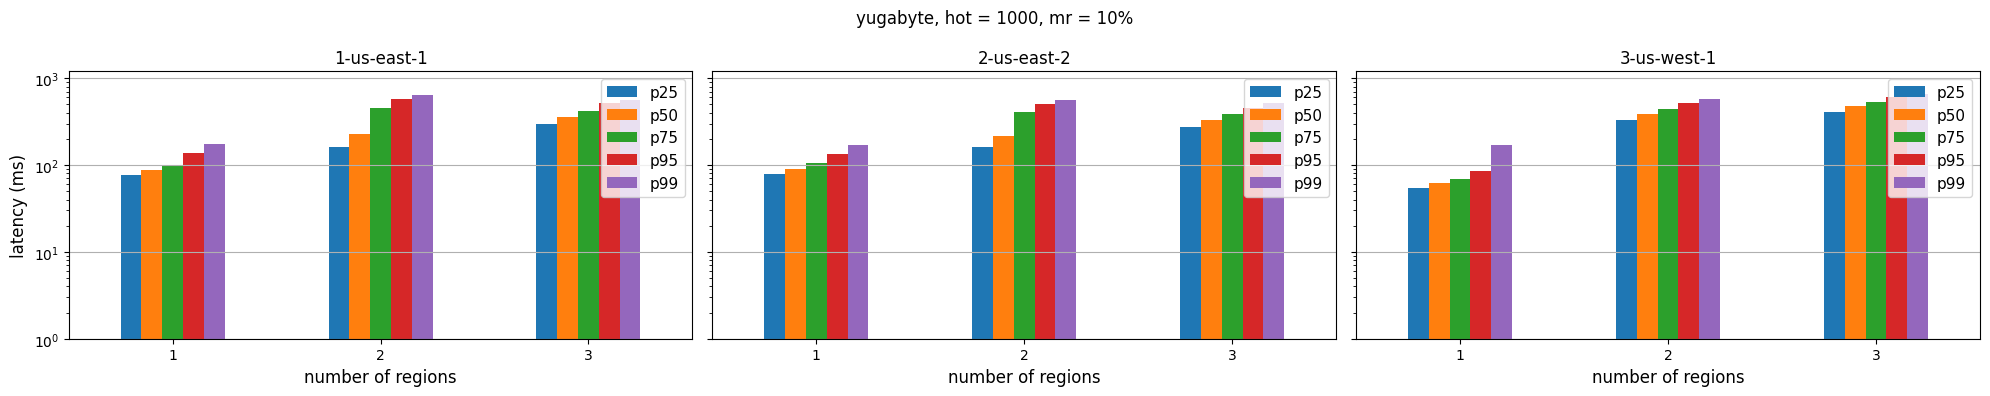

In [113]:
plot_latency(10, 1000)